In [1]:
## build researcher events, student events, and self-study events
## researcher are simply those with NH citations

In [2]:
import sys
import pandas as pd
import time
import datetime

In [3]:
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
from nanoHUB.application import Application

application = Application.get_instance()
nanohub_db = application.new_db_engine('nanohub')
nanohub_metrics_db = application.new_db_engine('nanohub_metrics')
wang159_myrmekes_db = application.new_db_engine('rfm_data')

salesforce = application.new_salesforce_engine()
db_s = salesforce

nanoHUB - Serving Students, Researchers & Instructors
Obtained Salesforce access token ...... True


## Figure: active simulation users by geolocation

In [5]:
## need to do iterative importing once again

In [6]:
import os
cwd = os.getcwd()

In [7]:
## caching check 
try:
    user_breakdown_df = pd.read_csv(cwd+'/cached_data/geo_nh_user_breakdown.csv')
    print(user_breakdown_df)
    cache_flag = True
except:
    cache_flag = False

In [8]:
## determine starting year
if cache_flag == False:
    start_year_base = 1999 #2000
else:
#     print('check the saved file')
    start_year_base = int(user_breakdown_df['year_month'].to_list()[-1][:4])

In [9]:
start_year_base

1999

In [10]:
import datetime
today = datetime.datetime.today()

In [11]:
all_months_list = list()
for this_year in range(start_year_base+1,today.year+2):
    if cache_flag == True:
        for this_month in range(1,today.month+1):
            all_months_list.append(datetime.datetime(this_year, this_month, 1))
    else:
        for this_month in range(1,12+1):
            all_months_list.append(datetime.datetime(this_year, this_month, 1))

In [12]:
country_df = pd.DataFrame()
if cache_flag == False:
    if today.month != 12:
        country_df['year_month'] = all_months_list[:-12-(12-today.month)]

In [13]:
country_df

,year_month
0,2000-01-01
1,2000-02-01
2,2000-03-01
3,2000-04-01
4,2000-05-01
...,...
261,2021-10-01
262,2021-11-01
263,2021-12-01
264,2022-01-01


In [14]:
usa = []
china = []
eu = []
india = []
other = []
eu_list = ['BE','BG','EL','CZ','DK','DE','EE','IE','ES','FR','HR','IT','CY','LV',\
          'LT','LU','HU','MT','NL','AT','PL','PT','RO','SI','SK','FI','SE','IS',\
           'NO','LI','CH','UK','ME','MK','AL','RS','TR','BA','XK','AM','AZ','BY',\
           'MD','GE','UA','RU']

In [15]:
from copy import deepcopy
import numpy as np

In [16]:
## computer has memory limits, so split toolstart into branches
start_year = deepcopy(start_year_base)

while start_year < today.year+1: #datetime.datetime.now().year:
    start_year += 1

    for i in range(1,13):
        if i < 10:
            start_date = r"'"+str(start_year-1)+r"-0"+str(i)+r"-01'"
            end_date = r"'"+str(start_year)+r"-0"+str(i)+r"-01'"
        else:
            start_date = r"'"+str(start_year-1)+r"-"+str(i)+r"-01'"
            end_date = r"'"+str(start_year)+r"-"+str(i)+r"-01'"

        sql_query_country = "select distinct user, countryip from toolstart where user != 'instanton' "\
        + "and user != 'gridstat' and datetime <= "+end_date+" and datetime >= "+start_date
        country_users = pd.read_sql_query(sql_query_country, nanohub_metrics_db)#.drop_duplicates()
        
        # run geography filter
        country_ipds = country_users['countryip'].to_list()
        
        bool_US = np.in1d(np.array(country_ipds),np.array(['US']))
        bool_EU = np.in1d(np.array(country_ipds),np.array(eu_list))
        bool_CN = np.in1d(np.array(country_ipds),np.array(['CN']))
        bool_IN = np.in1d(np.array(country_ipds),np.array(['IN']))
#         bool_OT = bool_US | bool_EU | bool_CN | bool_IN
        
        usa.append(len(np.where(bool_US)[0].tolist()))
        eu.append(len(np.where(bool_EU)[0].tolist()))
        china.append(len(np.where(bool_CN)[0].tolist()))
        india.append(len(np.where(bool_IN)[0].tolist()))
        other.append(len(country_ipds)-usa[-1]-eu[-1]-china[-1]-india[-1]) # len(np.where(bool_OT)[0].tolist()))
        
#         country_users.append(country_users.drop_duplicates().shape[0])

    print(start_year)

2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023


In [17]:
country_df.shape

(266, 1)

In [18]:
len(country_df['year_month'].to_list())

266

In [19]:
print(len(usa))
usa2 = usa[12:][:len(country_df['year_month'].to_list())]
print(len(usa2))

288
266


In [20]:
country_df['USA'] = usa[:len(country_df['year_month'].to_list())]
country_df['China'] = china[:len(country_df['year_month'].to_list())]
country_df['Europe'] = eu[:len(country_df['year_month'].to_list())]
country_df['India'] = india[:len(country_df['year_month'].to_list())]
country_df['Other'] = other[:len(country_df['year_month'].to_list())]

In [21]:
country_df

,year_month,USA,China,Europe,India,Other
0,2000-01-01,0,0,0,0,0
1,2000-02-01,0,0,0,0,0
2,2000-03-01,125,0,10,0,1
3,2000-04-01,188,0,15,1,1
4,2000-05-01,231,0,18,1,2
...,...,...,...,...,...,...
261,2021-10-01,9187,460,3938,4381,7053
262,2021-11-01,8842,470,3977,4139,7186
263,2021-12-01,8556,467,3997,4198,7373
264,2022-01-01,8312,462,3814,4062,7255


In [22]:
country_df['Total'] = \
np.array(usa[:len(country_df['year_month'].to_list())])+\
np.array(china[:len(country_df['year_month'].to_list())])+\
np.array(eu[:len(country_df['year_month'].to_list())])+\
np.array(india[:len(country_df['year_month'].to_list())])+\
np.array(other[:len(country_df['year_month'].to_list())])

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [24]:
import re

In [25]:
## read the dev_flags.txt to determine where to save
with open(cwd+'/dev_flags.txt','r') as f:
    raw_flags = f.read()
flag_pattern = re.compile(r'= \w+')
flags1 = re.findall(flag_pattern,raw_flags)    
flags_result = [i[2:] for i in flags1]
dev_flag = flags_result[0]
prod_flag = flags_result[1]

[WARNING] [backend_ps - matplotlib.backends.backend_ps]: The PostScript backend does not support transparency; partially transparent artists will be rendered opaque. [backend_ps._is_transparent:303]


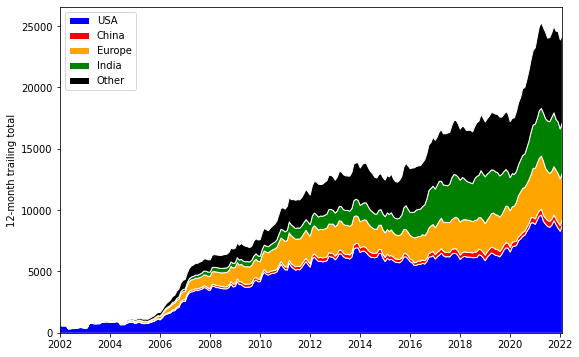

In [26]:
plt.figure(figsize=(9,6))
plt.stackplot(country_df['year_month'], \
              country_df[country_df.columns.to_list()[1:-1]].to_numpy().T, \
             labels=country_df.columns.to_list()[1:-1], \
             colors=['blue', 'red', 'orange', 'green', 'black'],\
             edgecolor='white');

plt.legend(loc='upper left');
plt.ylabel('12-month trailing total')
plt.xlim([datetime.datetime(2002,1,1), datetime.datetime(today.year,today.month,1)])

if dev_flag == 'True':
    plt.savefig(cwd+'/plots_local/simusers_geo_12months.eps', dpi=1000, bbox_inches='tight')
    plt.savefig(cwd+'/plots_local/simusers_geo_12months.pdf', dpi=1000, bbox_inches='tight')
    plt.savefig(cwd+'/plots_local/simusers_geo_12months.png', dpi=1000, bbox_inches='tight')
elif prod_flag == 'True':
    plt.savefig(cwd+'/plots_production/simusers_geo_12months.eps', dpi=1000, bbox_inches='tight')
    plt.savefig(cwd+'/plots_production/simusers_geo_12months.pdf', dpi=1000, bbox_inches='tight')
    plt.savefig(cwd+'/plots_production/simusers_geo_12months.png', dpi=1000, bbox_inches='tight')
else:
    print('no printing flag is active')
# plt.show()

[WARNING] [backend_ps - matplotlib.backends.backend_ps]: The PostScript backend does not support transparency; partially transparent artists will be rendered opaque. [backend_ps._is_transparent:303]


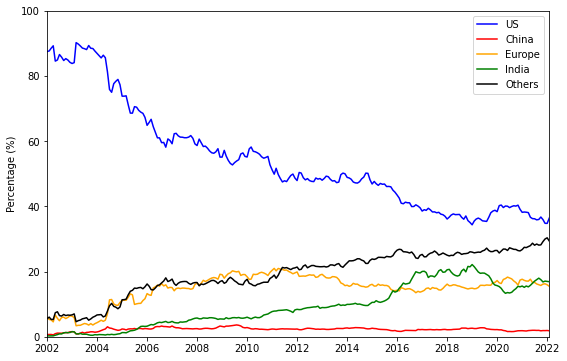

In [27]:
plt.figure(figsize=(9,6))
plt.plot(country_df['year_month'], \
         country_df['USA'].to_numpy()/country_df['Total'].to_numpy() *100\
         , label='US', color='blue');
plt.plot(country_df['year_month'], \
         country_df['China'].to_numpy()/country_df['Total'].to_numpy() *100\
         , label='China', color='red');
plt.plot(country_df['year_month'], \
         country_df['Europe'].to_numpy()/country_df['Total'].to_numpy() *100\
         , label='Europe', color='orange');
plt.plot(country_df['year_month'], \
         country_df['India'].to_numpy()/country_df['Total'].to_numpy() *100\
         , label='India', color='green');
plt.plot(country_df['year_month'], \
         country_df['Other'].to_numpy()/country_df['Total'].to_numpy() *100\
         , label='Others', color='black');

plt.xlim([datetime.datetime(2002,1,1), datetime.datetime(today.year,today.month,1)])
plt.ylim([0, 100])
plt.legend(loc='upper right');
plt.ylabel('Percentage (%)')

if dev_flag == 'True':
    plt.savefig(cwd+'/plots_local/simusers_geo_12months_percent.eps', dpi=1000, bbox_inches='tight')
    plt.savefig(cwd+'/plots_local/simusers_geo_12months_percent.pdf', dpi=1000, bbox_inches='tight')
    plt.savefig(cwd+'/plots_local/simusers_geo_12months_percent.png', dpi=1000, bbox_inches='tight')
elif prod_flag == 'True':
    plt.savefig(cwd+'/plots_production/simusers_geo_12months_percent.eps', dpi=1000, bbox_inches='tight')
    plt.savefig(cwd+'/plots_production/simusers_geo_12months_percent.pdf', dpi=1000, bbox_inches='tight')
    plt.savefig(cwd+'/plots_production/simusers_geo_12months_percent.png', dpi=1000, bbox_inches='tight')
else:
    print('no printing flag is active')

# plt.show()

In [28]:
country_df.to_csv(cwd+'/cached_data/simuser_geo_12months.csv')